In [ ]:
!pip install -q autogluon imbalanced-learn shap pandas matplotlib seaborn


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from autogluon.tabular import TabularPredictor
import warnings
import subprocess
import sys
import shutil
import traceback
from collections import Counter

# Suppress warnings
warnings.filterwarnings('ignore')

# Paths
train_path = "/Train_train_alln.csv"
test_path = "/ADNI_othernn.csv"
output_dir = "/cogdx_results_n1.5115"
os.makedirs(output_dir, exist_ok=True)


# Class name mapping for original 6 classes
CLASS_NAMES = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Define diagnostic features (adjust as needed)
diagnostic_features = ['Diagnosis_AD', 'Diagnosis_Control']

# =============================================================================
# STEP 1: DATA LOADING AND PREPROCESSING
# =============================================================================
print("Loading and preprocessing data...")

# Load training data - handle missing cogdx values
df_train = pd.read_csv(train_path)
if df_train['cogdx'].isna().any():
    print(f"Training set has {df_train['cogdx'].isna().sum()} missing cogdx values. Dropping these rows.")
    df_train = df_train.dropna(subset=['cogdx'])
df_train['cogdx'] = df_train['cogdx'].astype(int)

# Load test data - don't process cogdx since it's our target
df_test = pd.read_csv(test_path)

# Identify non-feature columns
non_feature_columns = ['ID', 'cogdx']

# Get training features (all columns except non-feature)
training_features = [col for col in df_train.columns if col not in non_feature_columns]
non_diagnostic_features = [col for col in training_features if col not in diagnostic_features]

# Compute training medians for each feature
training_medians = {}
for feature in non_diagnostic_features:
    if df_train[feature].dtype in ['float64', 'int64']:
        training_medians[feature] = df_train[feature].median()

# Handle missing values in training set
for feature in training_features:
    if df_train[feature].isnull().any():
        if feature in diagnostic_features:
            # For diagnostic features, use mode (most frequent diagnosis)
            mode_val = df_train[feature].mode()[0]
            df_train[feature].fillna(mode_val, inplace=True)
        else:
            # For non-diagnostic, use median
            df_train[feature].fillna(training_medians.get(feature, 0), inplace=True)

# =============================================================================
# STEP 1.5: ADVANCED IMPUTATION FOR MISSING FEATURES IN TEST SET
# =============================================================================
print("Handling missing features in test set...")

def impute_missing_features(train_df, test_df, diagnostic_features, non_diagnostic_features):
    """Advanced imputation for missing features in test data"""
    # Identify missing features in test set
    missing_features = set(training_features) - set(test_df.columns)

    # Handle non-diagnostic features first
    for feature in missing_features:
        if feature in non_diagnostic_features:
            # Use training median for missing non-diagnostic features
            test_df[feature] = training_medians.get(feature, 0)
            print(f"Added missing non-diagnostic feature: {feature} (set to {training_medians.get(feature, 0)})")

    # Now handle diagnostic features using predictive imputation
    for feature in missing_features:
        if feature in diagnostic_features:
            print(f"Imputing diagnostic feature: {feature}")

            # Prepare data for imputation model
            X_train = train_df[non_diagnostic_features]
            y_train = train_df[feature]

            # Train a classifier to predict the diagnostic feature
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)

            # Predict missing diagnostic feature
            X_test = test_df[non_diagnostic_features]
            test_df[feature] = model.predict(X_test)
            print(f"Imputed {feature} using predictive model")

    return test_df

# Apply advanced imputation to test set
df_test = impute_missing_features(df_train, df_test, diagnostic_features, non_diagnostic_features)

# Handle missing values in existing test features
for feature in training_features:
    if feature in df_test.columns and df_test[feature].isnull().any():
        if feature in diagnostic_features:
            # For diagnostic features, use mode from training
            mode_val = df_train[feature].mode()[0]
            df_test[feature].fillna(mode_val, inplace=True)
        else:
            # For non-diagnostic, use training median
            df_test[feature].fillna(training_medians.get(feature, 0), inplace=True)

# =============================================================================
# STEP 2: DATA VISUALIZATION AND CLASS BALANCING
# =============================================================================
print("Visualizing data distributions and balancing classes...")

# Plot class distribution before balancing
plt.figure(figsize=(12, 6))
sns.countplot(x='cogdx', data=df_train)
plt.title("Class Distribution (Training Data - Before Balancing)")
plt.xticks([0, 1, 2, 3, 4, 5], list(CLASS_NAMES.values()), rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "class_distribution_before.png"))
plt.close()

# Apply SMOTE to balance classes safely
X = df_train[training_features]
y = df_train['cogdx']

# Check original class distribution
print("Training class distribution before SMOTE:", Counter(y))

# Determine minimum class count
min_class_count = min(Counter(y).values())

# Set k_neighbors for SMOTE safely
k_neighbors = min(5, min_class_count - 1)  # Don't exceed min_class_count - 1
k_neighbors = max(1, k_neighbors)  # Ensure at least 1
print(f"Using k_neighbors={k_neighbors} for SMOTE")

# Apply SMOTE with adjusted k_neighbors
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Create balanced DataFrame
df_train_balanced = pd.DataFrame(X_resampled, columns=training_features)
df_train_balanced['cogdx'] = y_resampled

# Plot class distribution after balancing
plt.figure(figsize=(12, 6))
sns.countplot(x='cogdx', data=df_train_balanced)
plt.title("Class Distribution (Training Data - After SMOTE)")
plt.xticks([0, 1, 2, 3, 4, 5], list(CLASS_NAMES.values()), rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "class_distribution_after.png"))
plt.close()

# =============================================================================
# STEP 3: STRATIFIED TRAIN-VALIDATION SPLIT
# =============================================================================
print("Splitting data...")
train_df, val_df = train_test_split(
    df_train_balanced,
    test_size=0.25,
    stratify=df_train_balanced['cogdx'],
    random_state=42
)

# =============================================================================
# STEP 4: MODEL TRAINING WITH CLASS BALANCING AND CALIBRATION
# =============================================================================
print("Training models with enhanced class balancing...")

# Define hyperparameters for 6-class classification
hyperparameters = {
    "GBM": [
        {"class_weight": "balanced", "extra_trees": True, "ag_args": {"name_suffix": "LightGBM_Balanced"}},
        {"class_weight": {1: 2.0, 2: 1.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.5}, "extra_trees": True, "ag_args": {"name_suffix": "LightGBM_Weighted"}}
    ],
    "CAT": [
        {"class_weight": "balanced", "ag_args": {"name_suffix": "CatBoost_Balanced"}},
        {"class_weights": [2.0, 1.5, 1.0, 1.0, 1.0, 1.5], "ag_args": {"name_suffix": "CatBoost_Weighted"}}
    ],
    "XGB": [
        {"class_weight": "balanced", "ag_args": {"name_suffix": "XGBoost_Balanced"}},
        {"class_weight": {1: 2.0, 2: 1.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.5}, "ag_args": {"name_suffix": "XGBoost_Weighted"}}
    ],
    "RF": [
        {"class_weight": "balanced_subsample", "ag_args": {"name_suffix": "RF_Balanced"}},
        {"class_weight": {1: 2.0, 2: 1.5, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.5}, "ag_args": {"name_suffix": "RF_Weighted"}}
    ],
    "XT": [
        {"class_weight": "balanced_subsample", "ag_args": {"name_suffix": "XT_Balanced"}}
    ],
    "KNN": {"weights": "distance"},
    "NN_TORCH": [
        {
            "num_epochs": 100,
            "weight_decay": 1e-4,
            "activation": "leaky_relu",
            "dropout_prob": 0.3,
            "class_weight": "balanced",
            "ag_args": {"name_suffix": "DeepNet_Balanced"}
        },
        {
            "num_epochs": 150,
            "layers": [256, 128, 64],
            "learning_rate": 1e-3,
            "class_weights": [2.0, 1.5, 1.0, 1.0, 1.0, 1.5],
            "ag_args": {"name_suffix": "DeepNet_Weighted"}
        }
    ],
    "LR": [
        {
            "class_weight": "balanced",
            "penalty": "l1",
            "solver": "liblinear",
            "C": 0.1,
            "ag_args": {"name_suffix": "Lasso_Balanced"}
        }
    ],
    "FASTAI": {
        "bs": 64,
        "emb_drop": 0.1,
        "layers": [200, 100],
        "class_weight": "balanced"
    },
    "TABPFNMIX": {
        "N_ensemble_configurations": 2
    },
    "TABPFNV2": {
        "N_ensemble_configurations": 2
    },
    "AG_AUTOMM": {
        "class_weight": "balanced",
        "ag_args": {"name_suffix": "Multimodal"}
    },
    "IM_RULEFIT": {
        "max_rules": 20,
        "class_weight": "balanced"
    },
    "IM_GREEDYTREE": {
        "max_depth": 7,
        "class_weight": "balanced"
    },
    "IM_FIGS": {
        "max_rules": 15,
        "class_weight": "balanced"
    },
    "IM_HSTREE": {
        "max_depth": 6,
        "class_weight": "balanced"
    },
    "IM_BOOSTEDRULES": {
        "n_estimators": 30,
        "class_weight": "balanced"
    }
}

# Add weighted ensemble configuration
hyperparameters["ENS_WEIGHTED"] = {}

# =============================================================================
# MODEL TRAINING
# =============================================================================
predictor = TabularPredictor(
    label='cogdx',
    path=os.path.join(output_dir, "autogluon_model"),
    problem_type='multiclass',
    eval_metric='balanced_accuracy'
).fit(
    train_data=train_df,
    tuning_data=val_df,
    presets='best_quality',
    time_limit=14400,  # 4 hours
    hyperparameters=hyperparameters,
    verbosity=3,
    calibrate=True,
    num_bag_folds=10,
    num_stack_levels=2,
    num_bag_sets=5,
    dynamic_stacking=True,
    refit_full=True,
    use_bag_holdout=True
)

# =============================================================================
# STEP 5: VALIDATION EVALUATION AND ERROR ANALYSIS
# =============================================================================
print("Evaluating validation performance...")

# Generate predictions with calibrated probabilities
val_preds = predictor.predict(val_df[training_features])
val_df['prediction'] = val_preds
val_df.to_csv(os.path.join(output_dir, "validation_predictions.csv"), index=False)

# Classification report
report = classification_report(val_df['cogdx'], val_df['prediction'], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv(os.path.join(output_dir, "validation_performance.csv"))

# Calculate balanced accuracy
balanced_acc = balanced_accuracy_score(val_df['cogdx'], val_df['prediction'])

# Confusion matrix with class names
class_labels = [str(cls) for cls in predictor.class_labels]
class_names = [CLASS_NAMES[int(cls)] for cls in class_labels]

cm = confusion_matrix(val_df['cogdx'], val_df['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Validation)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "confusion_matrix.png"))
plt.close()

# Error analysis: Identify misclassified cases
val_df['correct'] = val_df['cogdx'] == val_df['prediction']
misclassified = val_df[~val_df['correct']]
misclassified.to_csv(os.path.join(output_dir, "misclassified_cases.csv"), index=False)

# =============================================================================
# STEP 6: TEST PREDICTIONS
# =============================================================================
print("Generating test predictions...")
test_preds = predictor.predict(df_test[training_features])

# Create a new DataFrame for results
results_df = df_test[['ID']].copy()
results_df['predicted_cogdx'] = test_preds

# If we have true labels in test set (for evaluation), include them
if 'cogdx' in df_test.columns:
    # Handle missing true labels
    if df_test['cogdx'].isna().any():
        print(f"Test set has {df_test['cogdx'].isna().sum()} missing true cogdx values. These won't be used for evaluation.")
    results_df['true_cogdx'] = df_test['cogdx']

    # Calculate accuracy only for samples with true labels
    valid_mask = results_df['true_cogdx'].notna()
    if valid_mask.any():
        valid_results = results_df[valid_mask]
        
        # Convert labels to integers to avoid continuous vs multiclass mismatch
        y_true = valid_results['true_cogdx'].astype(int)
        y_pred = valid_results['predicted_cogdx'].astype(int)
        
        test_balanced_acc = balanced_accuracy_score(y_true, y_pred)
        print(f"Test Balanced Accuracy (on available labels): {test_balanced_acc:.4f}")

        # Save classification report
        test_report = classification_report(
            y_true,
            y_pred,
            output_dict=True
        )
        test_report_df = pd.DataFrame(test_report).transpose()
        test_report_df.to_csv(os.path.join(output_dir, "test_performance.csv"))

# Save predictions
results_df.to_csv(os.path.join(output_dir, "test_predictions.csv"), index=False)

# =============================================================================
# STEP 7: FEATURE ANALYSIS
# =============================================================================
print("Analyzing feature importance...")

# Feature importance
feat_imp = predictor.feature_importance(val_df)
feat_imp.to_csv(os.path.join(output_dir, "feature_importance.csv"))

# Plot top features
if not feat_imp.empty:
    top_features = feat_imp['importance'].nlargest(15)
    plt.figure(figsize=(10, 6))
    top_features.plot(kind='barh', color='skyblue')
    plt.title('Top 15 Features by Importance')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "top_features.png"))
    plt.close()

# =============================================================================
# STEP 8: SHAP ANALYSIS
# =============================================================================
print("Running SHAP analysis...")

def install_shap():
    """Install SHAP if not available"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap"])
        import shap
        return shap
    except:
        return None

try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    print("SHAP not found. Attempting to install...")
    shap = install_shap()
    SHAP_AVAILABLE = shap is not None

if SHAP_AVAILABLE:
    try:
        # Get best model
        leaderboard = predictor.leaderboard()
        best_model_name = leaderboard.iloc[0]['model']
        model_type = best_model_name.split('_')[0]

        # Load model
        model = predictor._trainer.load_model(best_model_name)

        # Prepare SHAP data
        X_val = val_df[training_features]
        sample_size = min(100, len(X_val))
        X_val_sample = X_val.sample(sample_size, random_state=42)

        # Create explainer based on model type
        if model_type in ['LightGBM', 'XGBoost', 'RandomForest', 'ExtraTrees']:
            explainer = shap.TreeExplainer(model.model)
            shap_values = explainer.shap_values(X_val_sample)

            # SHAP summary plot
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_val_sample, show=False, class_names=class_names)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "shap_summary.png"))
            plt.close()

            # Class-specific SHAP plots
            for i, class_name in enumerate(class_names):
                plt.figure(figsize=(12, 8))
                shap.summary_plot(shap_values[i], X_val_sample, show=False)
                plt.title(f"SHAP Values for {class_name}")
                plt.tight_layout()
                plt.savefig(os.path.join(output_dir, f"shap_class_{i+1}.png"))
                plt.close()
        else:
            print(f"SHAP not supported for model type: {model_type}")
    except Exception as e:
        with open(os.path.join(output_dir, "shap_error.txt"), "w") as f:
            f.write(f"SHAP failed: {str(e)}")

# =============================================================================
# STEP 9: FINAL REPORTING AND CLEANUP
# =============================================================================
print("Saving final results...")

# Save leaderboard
leaderboard = predictor.leaderboard()
leaderboard.to_csv(os.path.join(output_dir, "model_leaderboard.csv"))

# Calculate class distribution in validation predictions
val_class_dist = val_df['prediction'].value_counts(normalize=True).sort_index()

# Save summary report
with open(os.path.join(output_dir, "summary_report.txt"), "w") as f:
    f.write("COGNITIVE IMPAIRMENT PREDICTION REPORT (6-CLASS)\n")
    f.write("=" * 50 + "\n\n")

    f.write("MODEL PERFORMANCE SUMMARY\n")
    f.write("-" * 30 + "\n")
    f.write(f"Best Model: {leaderboard.iloc[0]['model']}\n")
    f.write(f"Validation Balanced Accuracy: {balanced_acc:.4f}\n")
    f.write(f"Overall Accuracy: {report['accuracy']:.4f}\n")
    f.write(f"Macro F1-score: {report['macro avg']['f1-score']:.4f}\n\n")

    f.write("CLASS DISTRIBUTION IN VALIDATION PREDICTIONS\n")
    f.write("-" * 30 + "\n")
    f.write("Validation Set:\n")
    for class_id in sorted(val_class_dist.index):
        f.write(f"  {CLASS_NAMES[class_id]}: {val_class_dist[class_id]:.2%}\n")

    f.write("\nCLASS-WISE PERFORMANCE\n")
    f.write("-" * 30 + "\n")

    # Get class labels from report (filter out non-class keys)
    class_keys = [str(cls) for cls in predictor.class_labels]

    for label in class_keys:
        class_id = int(label)
        class_name = CLASS_NAMES[class_id]
        f.write(f"Class {class_id} ({class_name}):\n")
        f.write(f"  Precision: {report[label]['precision']:.4f}\n")
        f.write(f"  Recall:    {report[label]['recall']:.4f}\n")
        f.write(f"  F1-score:  {report[label]['f1-score']:.4f}\n")
        f.write(f"  Support:   {report[label]['support']}\n\n")

    f.write("TOP FEATURES\n")
    f.write("-" * 30 + "\n")
    if not feat_imp.empty:
        top_features = feat_imp['importance'].nlargest(10)
        for i, (feature, importance) in enumerate(top_features.items(), 1):
            f.write(f"{i}. {feature}: {importance:.4f}\n")

    f.write("\nMODEL LEADERBOARD\n")
    f.write("-" * 30 + "\n")
    f.write(leaderboard[['model', 'score_val']].to_string(index=False))

# Save package versions
with open(os.path.join(output_dir, "package_versions.txt"), "w") as f:
    f.write(f"AutoGluon: {predictor.version}\n")
    f.write(f"Pandas: {pd.__version__}\n")
    f.write(f"Python: {sys.version}\n")

# Extended SHAP analysis
print("Running extended SHAP analysis...")

if SHAP_AVAILABLE:
    try:
        # Get best base model (exclude ensembles)
        base_model_leaderboard = leaderboard[
            (~leaderboard['model'].str.contains('WeightedEnsemble')) &
            (~leaderboard['model'].str.contains('_BAG_L2'))
        ]
        if not base_model_leaderboard.empty:
            best_model_name = base_model_leaderboard.iloc[0]['model']
            print(f"Using best base model: {best_model_name}")

            # Load model
            best_model = predictor._trainer.load_model(best_model_name)

            # Prepare validation data
            X_val = val_df[training_features]
            sample_size = min(100, len(X_val))
            X_val_sample = X_val.sample(sample_size, random_state=42)

            # Try TreeExplainer
            try:
                raw_model = best_model.model
                if raw_model is not None:
                    explainer = shap.TreeExplainer(raw_model)
                    shap_values = explainer.shap_values(X_val_sample)
                    print("Used TreeExplainer.")
                else:
                    raise ValueError("Raw model is None")
            except Exception as tree_error:
                print(f"TreeExplainer failed: {tree_error}")
                print("Falling back to KernelExplainer...")
                def predict_proba_wrapper(data):
                    return best_model.predict_proba(data)
                background = X_val_sample.sample(10, random_state=42)
                explainer = shap.KernelExplainer(predict_proba_wrapper, background)
                shap_values = explainer.shap_values(X_val_sample, nsamples=50)
                print("Used KernelExplainer.")

            # Summary plot
            plt.figure(figsize=(14, 10))
            if isinstance(shap_values, list):
                shap.summary_plot(shap_values, X_val_sample, show=False, class_names=class_names)
            else:
                shap.summary_plot(shap_values, X_val_sample, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(output_dir, "shap_summary_extended.png"))
            plt.close()
            print("Saved extended SHAP summary plot.")
    except Exception as e:
        print(f"Extended SHAP analysis failed: {str(e)}")
        with open(os.path.join(output_dir, "shap_error_extended.txt"), "w") as f:
            f.write(f"Extended SHAP failed: {str(e)}\n\n")
            f.write(traceback.format_exc())

# Zip results
print("Zipping results folder...")
shutil.make_archive(output_dir, 'zip', output_dir)
print(f"Results zipped to: {output_dir}.zip")

print("=" * 50)
print("PROCESS COMPLETED SUCCESSFULLY!")
print(f"All results saved to: {output_dir}")
print("=" * 50)

In [ ]:
#Predict for a single individual


import os
os.environ['AUTOGLUON_SKIP_ENV_VALIDATION'] = '1'  # Skip environment validation

import pandas as pd
import numpy as np
from autogluon.tabular import TabularPredictor
import warnings
import shutil

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)

# Configuration - UPDATE THIS PATH TO YOUR MODEL LOCATION
MOUNTED_MODEL_DIR = "/cogdx_results_n1.5/autogluon_model"  # Where model is mounted
WORKING_DIR = os.getcwd()

# Find predictor.pkl in the mounted directory
print("="*50)
print("Searching for predictor.pkl...")
predictor_path = None
for root, dirs, files in os.walk(MOUNTED_MODEL_DIR):
    if "predictor.pkl" in files:
        predictor_path = root
        print(f"Found predictor.pkl at: {predictor_path}")
        break

if predictor_path is None:
    raise FileNotFoundError("Could not find predictor.pkl in model directory")

# Find WeightedEnsemble_L3 model
print("\nSearching for WeightedEnsemble_L3 model...")
ensemble_path = None
for root, dirs, files in os.walk(MOUNTED_MODEL_DIR):
    if "WeightedEnsemble_L3" in dirs and "model.pkl" in os.listdir(os.path.join(root, "WeightedEnsemble_L3")):
        ensemble_path = os.path.join(root, "WeightedEnsemble_L3")
        print(f"Found WeightedEnsemble_L3 at: {ensemble_path}")
        break

if ensemble_path is None:
    print("WARNING: Could not find WeightedEnsemble_L3 directory with model.pkl")

print("="*50)
print(f"Loading predictor from: {predictor_path}")

# Load predictor with version mismatch handling
try:
    # Explicitly handle version mismatch
    predictor = TabularPredictor.load(
        predictor_path, 
        require_version_match=False,  # Bypass version check
        require_py_version_match=False
    )
    print("Predictor loaded successfully with version mismatch bypassed")
except Exception as e:
    print(f"Error loading predictor: {str(e)}")
    # Try loading the predictor.pkl file directly
    try:
        predictor = TabularPredictor.load(
            os.path.join(predictor_path, "predictor.pkl"),
            require_version_match=False,
            require_py_version_match=False
        )
        print("Successfully loaded predictor from direct path with version mismatch bypassed")
    except Exception as e2:
        print(f"Direct load failed: {str(e2)}")
        raise RuntimeError("All model loading attempts failed")

print("="*50)
print(f"Model info:")
print(f"- Prediction problem type: {predictor.problem_type}")
print(f"- Label column: {predictor.label}")
print(f"- Feature names: {predictor.features()[:5]}... (total {len(predictor.features())} features)")

# Define sample input
sample_input = {
    "Age": 75,
    "race_Black_or_AA": 0,
    "race_HW": 0,
    "race_Asian": 0,
    "race_Other": 0,
    "race_NHW": 1,
    "race_unknown": 0,
    "PMI.h.": 7.5,
    "KCNH8": 0.12,
    "ZEB2": 0.45,
    "ST18": -0.35,
    "ZNF536": 1.02,
    "Gender_female": 1,
    "Gender_male": 0,
    "Diagnosis_AD": 1,
    "Diagnosis_Control": 0,
    "APOE_Status_22": 0,
    "APOE_Status_23": 0,
    "APOE_Status_24": 0,
    "APOE_Status_33": 0,
    "APOE_Status_34": 1,
    "APOE_Status_44": 0,
    "Braak_0": 0,
    "Braak_1": 0,
    "Braak_2": 0,
    "Braak_3": 0,
    "Braak_4": 1,
    "Braak_5": 0,
    "Braak_6": 0,
    "last_MMSE_0": 0,
    "last_MMSE_1": 0,
    "last_MMSE_2": 0,
    "last_MMSE_3": 0,
    "last_MMSE_6": 0,
    "last_MMSE_8": 0,
    "last_MMSE_10": 0,
    "last_MMSE_11": 0,
    "last_MMSE_12": 0,
    "last_MMSE_13": 0,
    "last_MMSE_14": 0,
    "last_MMSE_15": 1,
    "last_MMSE_16": 0,
    "last_MMSE_17": 0,
    "last_MMSE_18": 0,
    "last_MMSE_19": 0,
    "last_MMSE_20": 0,
    "last_MMSE_21": 0,
    "last_MMSE_22": 0,
    "last_MMSE_23": 0,
    "last_MMSE_24": 0,
    "last_MMSE_25": 0,
    "last_MMSE_26": 0,
    "last_MMSE_27": 0,
    "last_MMSE_28": 0,
    "last_MMSE_29": 0,
    "last_MMSE_30": 0,
    "Years_Education_10": 0,
    "Years_Education_12": 0,
    "Years_Education_13": 0,
    "Years_Education_14": 0,
    "Years_Education_15": 0,
    "Years_Education_16": 1,
    "Years_Education_17": 0,
    "Years_Education_18": 0,
    "Years_Education_19": 0,
    "Years_Education_20": 0,
    "Years_Education_21": 0,
    "Years_Education_22": 0,
    "Years_Education_23": 0,
    "Years_Education_24": 0,
    "Years_Education_25": 0,
    "Highest_Education_Level_Bachelors": 0,
    "Highest_Education_Level_Graduate (PhD/Masters)": 1,
    "Highest_Education_Level_High School": 0,
    "Highest_Education_Level_Professional": 0,
    "Highest_Education_Level_Trade School/ Tech School": 0
}

# Create DataFrame
df = pd.DataFrame([sample_input])
print(f"\nInput DataFrame shape before alignment: {df.shape}")

# Feature alignment
training_features = predictor.features()
print(f"Model expects {len(training_features)} features")

# Create aligned DataFrame with correct features
aligned_df = pd.DataFrame(columns=training_features)

# Add sample data to aligned DataFrame
for col in training_features:
    if col in sample_input:
        aligned_df[col] = [sample_input[col]]
    elif col.lower() in [k.lower() for k in sample_input.keys()]:
        # Case-insensitive match
        matched_key = [k for k in sample_input.keys() if k.lower() == col.lower()][0]
        aligned_df[col] = [sample_input[matched_key]]
        print(f"Matched feature: {matched_key} -> {col}")
    else:
        aligned_df[col] = [0]  # Default value
        print(f"Warning: Missing feature '{col}' - using default value 0")

df = aligned_df
print(f"Aligned DataFrame shape: {df.shape}")
print(f"First 5 features: {list(df.columns[:5])}")

# Generate predictions using WeightedEnsemble_L3
print(f"\nPredicting with WeightedEnsemble_L3...")
try:
    # Get prediction from the specific model
    prediction = predictor.predict(df, model="WeightedEnsemble_L3")
    predicted_class = prediction.iloc[0]
    
    # Get probabilities from the model
    proba = predictor.predict_proba(df, model="WeightedEnsemble_L3")
    print("Probability matrix:")
    print(proba)
    
    # Get confidence score
    confidence = proba.loc[:, predicted_class].iloc[0]
    
    print(f"Predicted cogdx: {predicted_class}")
    print(f"Confidence: {confidence:.2%}")
    
except Exception as e:
    print(f"Prediction with WeightedEnsemble_L3 failed: {str(e)}")
    print("Falling back to predictor's default model...")
    try:
        prediction = predictor.predict(df)
        predicted_class = prediction.iloc[0]
        proba = predictor.predict_proba(df)
        confidence = proba.loc[:, predicted_class].iloc[0] if not proba.empty else 0
        print(f"Predicted cogdx (fallback): {predicted_class}")
    except Exception as e2:
        print(f"All prediction methods failed: {str(e2)}")
        predicted_class = -1
        confidence = 0

# Add prediction to DataFrame
df["Predicted_cogdx"] = [predicted_class]
df["Confidence"] = [confidence]

# Save results
output_path = "cogdx_prediction.csv"
df.to_csv(output_path, index=False)

# Print final results
print("\n" + "="*50)
print("COGDX PREDICTION RESULTS")
print("="*50)
if predicted_class == 1:
    print("Predicted Cognitive Status: 1 (No Cognitive Impairment)")
elif predicted_class == 2:
    print("Predicted Cognitive Status: 2 (Mild Cognitive Impairment)")
elif predicted_class == 3:
    print("Predicted Cognitive Status: 3 (Alzheimer's Disease)")
else:
    print(f"Prediction failed with code: {predicted_class}")

print(f"Confidence: {confidence:.2%}")
print(f"Results saved to: {os.path.abspath(output_path)}")
print("="*50)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from autogluon.tabular import TabularPredictor
import numpy as np

MODEL_DIR = "/Train_train_all_noDERn_ADNI_other_noDERn/autogluon_model"
INPUT_DATA = "/Test_test_noDERn.csv"

STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

def main():
    # Load predictor with version checks disabled
    predictor = TabularPredictor.load(
        MODEL_DIR,
        require_version_match=False,  # Bypass AutoGluon version check
        require_py_version_match=False  # Bypass Python version check
    )
    input_df = pd.read_csv(INPUT_DATA)

    # Ensure all required features exist
    required_features = predictor.features()
    for feature in required_features:
        if feature not in input_df.columns:
            if feature in ['Diagnosis_AD', 'Diagnosis_Control']:
                input_df[feature] = np.nan
                print(f"Added column {feature} with NaN (no imputation)")
            else:
                X_val = predictor._trainer.load_X_val()
                if feature in X_val.select_dtypes(include=np.number).columns:
                    input_df[feature] = X_val[feature].median()
                    print(f"Imputed numeric feature {feature} with median {X_val[feature].median()}")
                else:
                    input_df[feature] = X_val[feature].mode()[0]
                    print(f"Imputed categorical feature {feature} with mode {X_val[feature].mode()[0]}")

    # Make predictions
    predictions = predictor.predict(input_df)
    proba = predictor.predict_proba(input_df)

    # Prepare results
    results_df = input_df.copy()
    results_df["predicted_cogdx"] = predictions.values
    results_df["confidence"] = proba.max(axis=1).values
    results_df["predicted_status"] = results_df["predicted_cogdx"].map(STATUS_MAP)

    # Save results
    results_df.to_csv("cogdx_predictions.csv", index=False)
    print("\nSaved predictions to 'cogdx_predictions.csv'")

    # Visualization
    plt.figure(figsize=(10, 6))
    results_df["predicted_status"].value_counts().plot(kind='bar', title='Prediction Distribution', color='orange')
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("prediction_distribution.png")
    print("Saved prediction distribution visualization")

    print("\nPrediction Summary:")
    print(results_df['predicted_status'].value_counts())

if __name__ == "__main__":
    main()

File found at: /Users/martinnwadiugwu/Downloads/test_predictions_chrome_Train_train_all_ROS_MAP2.csv

Data Preview:
         ID  predicted_cogdx  cogdx_num
0  10100574                1        1.0
1  10101589                4        4.0
2  10202345                1        1.0
3  10203224                1        1.0
4  10205244                1        1.0

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Filtered dataset size: 589
Class distribution after filtering:
cogdx_num
4    204
1    189
2    149
5     29
6     10
3      8
Name: count, dtype: int64

Accuracy Ratio: 301/589 = 0.5110 (51.10%)


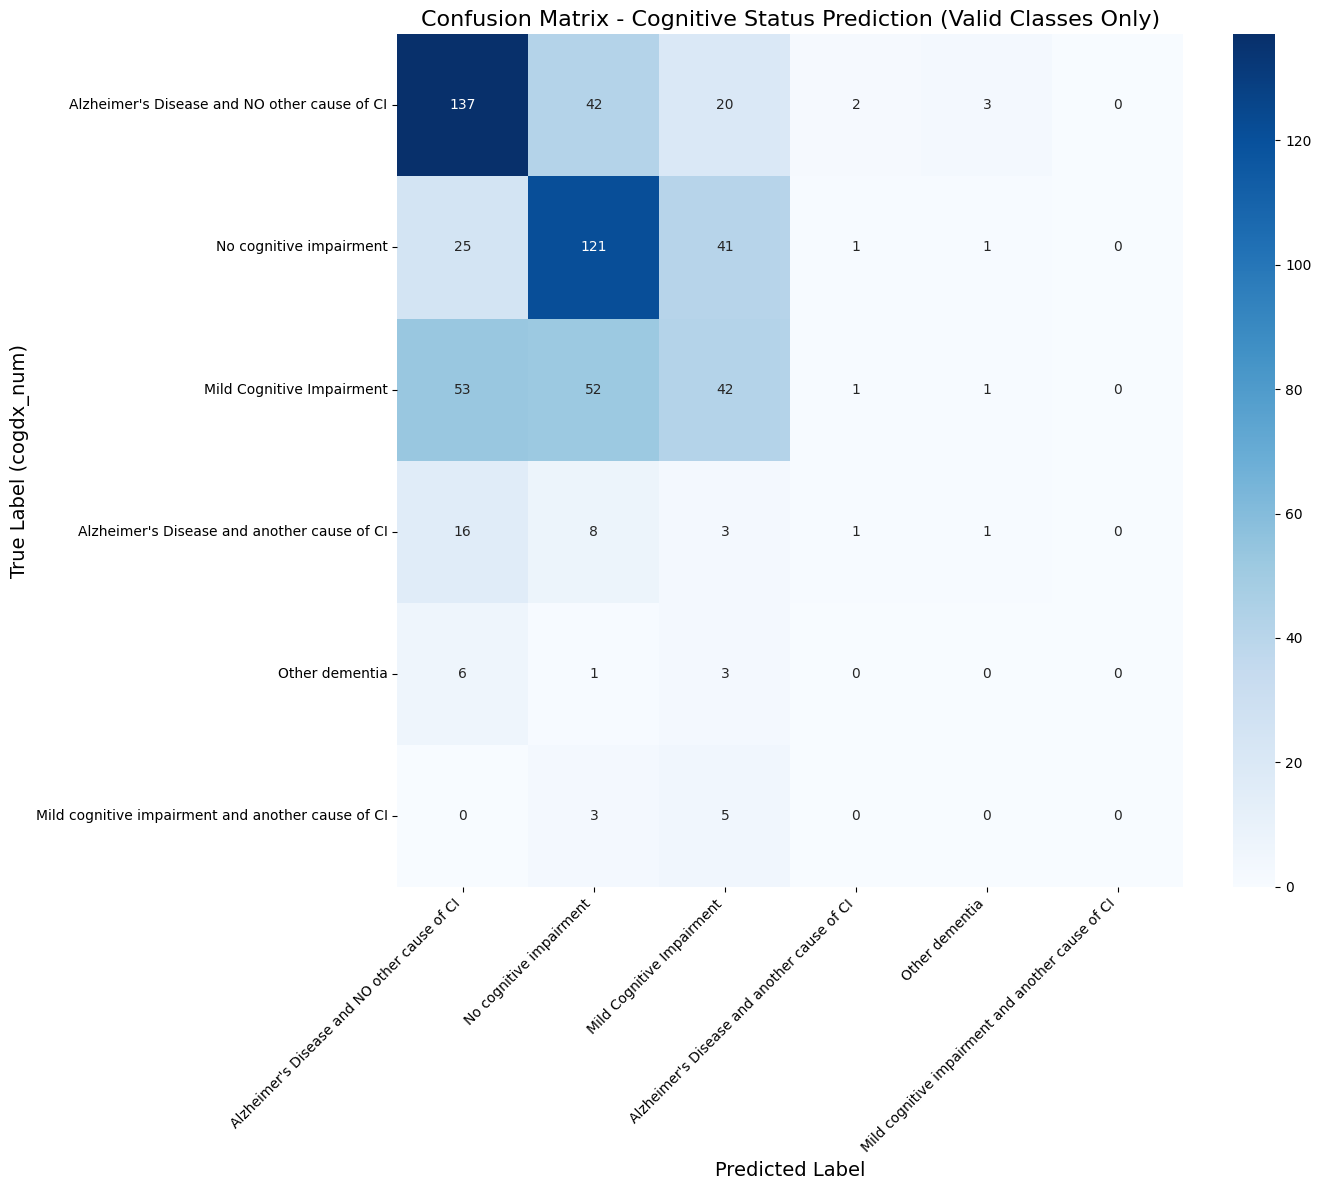


Detailed Classification Report (Valid Classes Only):
                                                   precision    recall  f1-score   support

     Alzheimer's Disease and NO other cause of CI       0.58      0.67      0.62       204
                          No cognitive impairment       0.53      0.64      0.58       189
                        Mild Cognitive Impairment       0.37      0.28      0.32       149
      Alzheimer's Disease and another cause of CI       0.20      0.03      0.06        29
                                   Other dementia       0.00      0.00      0.00        10
Mild cognitive impairment and another cause of CI       0.00      0.00      0.00         8

                                         accuracy                           0.51       589
                                        macro avg       0.28      0.27      0.26       589
                                     weighted avg       0.47      0.51      0.49       589


Metrics DataFrame:
             

In [2]:
##ROS_MAP2


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path - use absolute path with home directory
file_path = os.path.expanduser("~/Downloads/test_predictions_chrome_Train_train_all_ROS_MAP2.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")




File found at: /Users/martinnwadiugwu/Downloads/models/Train_train_all_ADNI_other/new/cogdx_results_n1.51/test_predictions.csv

Data Preview:
   ID  predicted_cogdx  true_cogdx  cogdx_num
0   2                1         NaN          1
1   7                4         NaN          4
2  15                1         NaN          1
3  21                1         NaN          1
4  30                2         NaN          2

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Found 1 predictions for invalid classes. These will be treated as errors.

Filtered dataset size: 1107
Class distribution after filtering:
cogdx_num
2    517
1    500
4     90
Name: count, dtype: int64

Accuracy Ratio: 967/1107 = 0.8735 (87.35%)


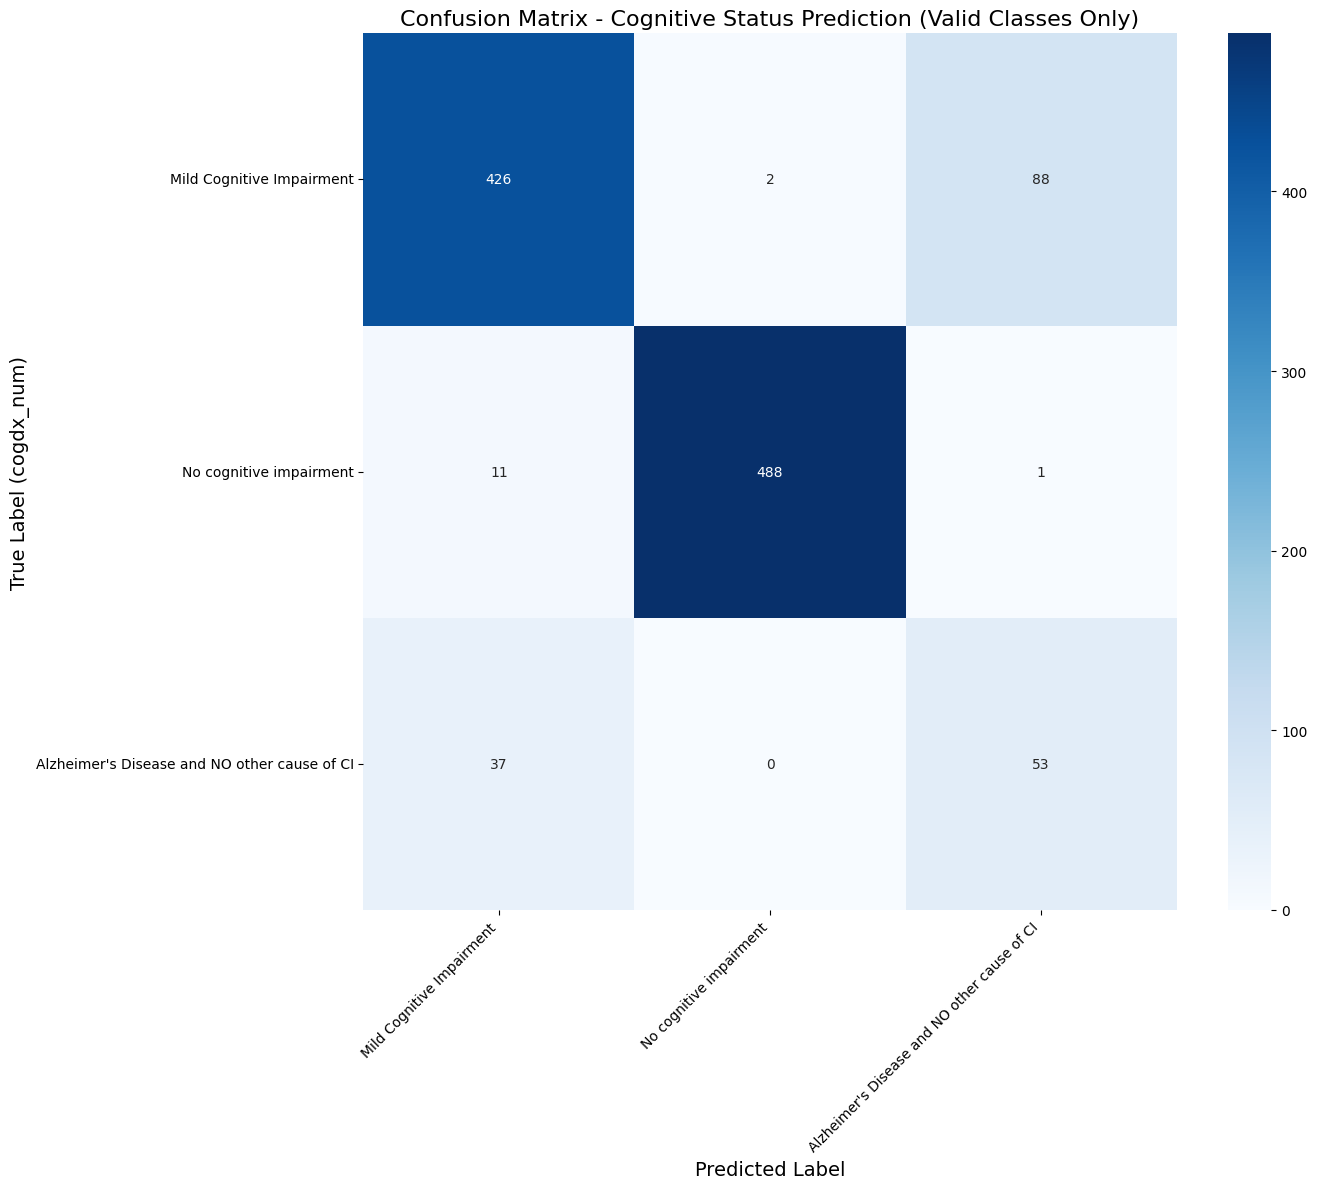


Detailed Classification Report (Valid Classes Only):
                                              precision    recall  f1-score   support

                   Mild Cognitive Impairment       0.90      0.82      0.86       517
                     No cognitive impairment       1.00      0.98      0.99       500
Alzheimer's Disease and NO other cause of CI       0.37      0.59      0.46        90

                                   micro avg       0.87      0.87      0.87      1107
                                   macro avg       0.76      0.80      0.77      1107
                                weighted avg       0.90      0.87      0.88      1107


Metrics DataFrame:
                                              precision    recall  f1-score  \
Mild Cognitive Impairment                      0.898734  0.823985  0.859738   
No cognitive impairment                        0.995918  0.976000  0.985859   
Alzheimer's Disease and NO other cause of CI   0.373239  0.588889  0.456897   
micro

In [5]:
#ADNI_other

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path
file_path = os.path.expanduser("~/Downloads/models/Train_train_all_ADNI_other/new/cogdx_results_n1.51/test_predictions.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")

File found at: /Users/martinnwadiugwu/Downloads/models/Train_train_all_noDER_ADNI_other_noDER_new/cogdx_results_n1.511/test_predictions.csv

Data Preview:
   ID  predicted_cogdx  true_cogdx  cogdx_num
0   2                1         NaN          1
1   7                2         NaN          4
2  15                1         NaN          1
3  21                1         NaN          1
4  30                2         NaN          2

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Found 3 predictions for invalid classes. These will be treated as errors.

Filtered dataset size: 1107
Class distribution after filtering:
cogdx_num
2    517
1    500
4     90
Name: count, dtype: int64

Accuracy Ratio: 1003/1107 = 0.9061 (90.61%)


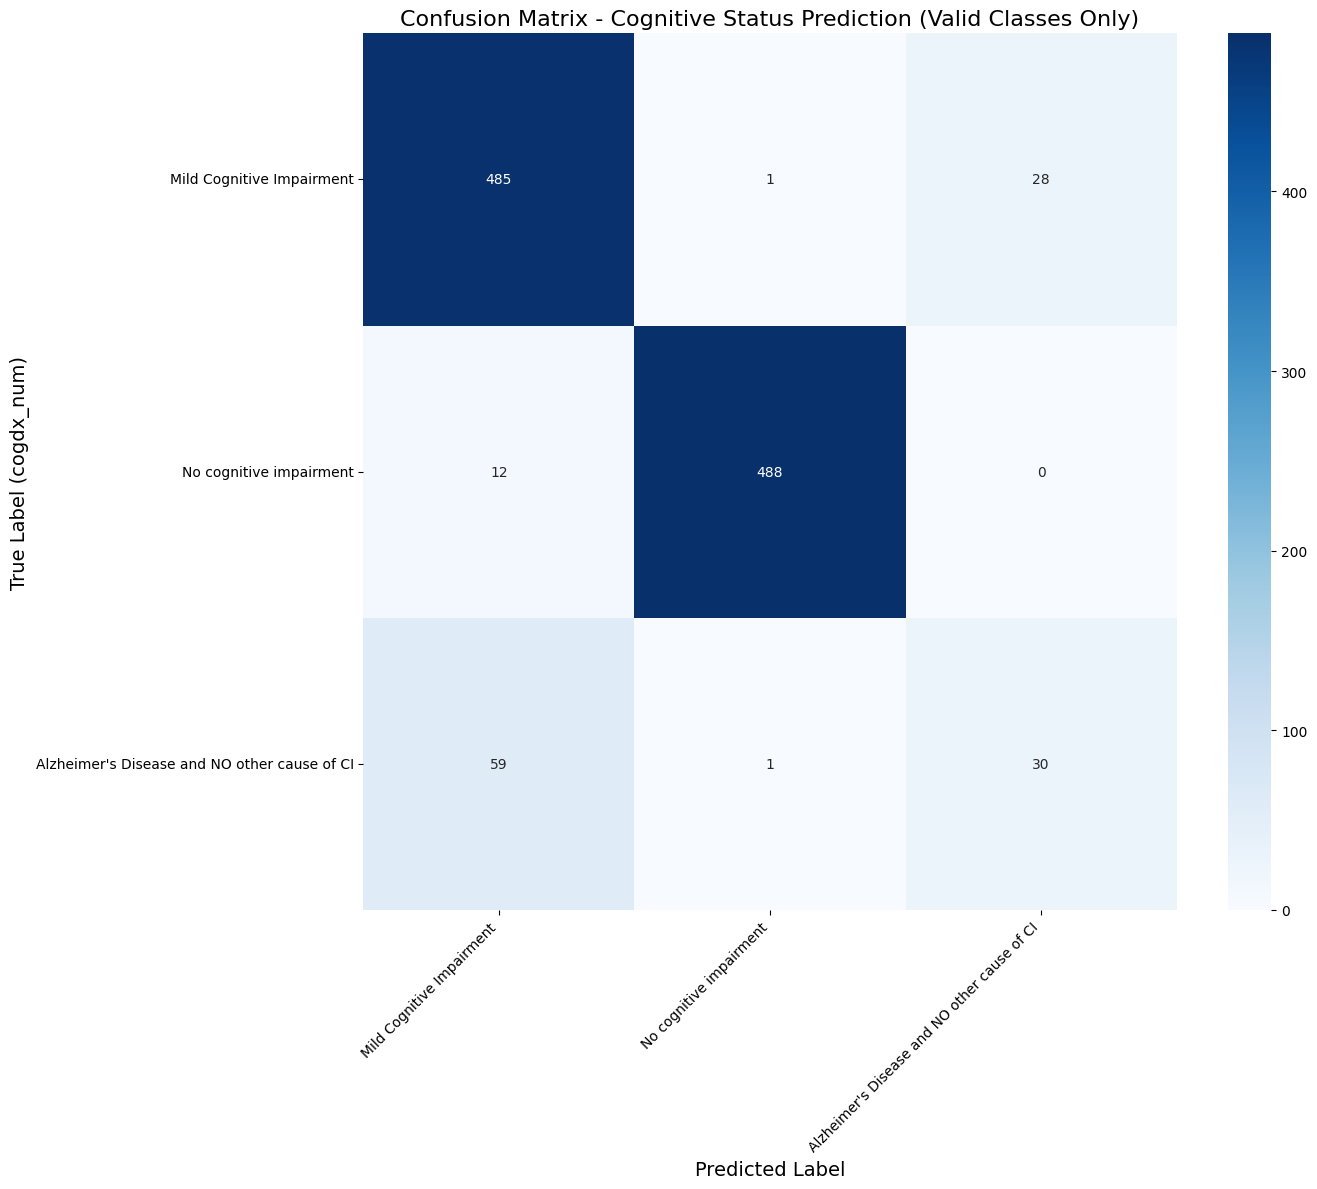


Detailed Classification Report (Valid Classes Only):
                                              precision    recall  f1-score   support

                   Mild Cognitive Impairment       0.87      0.94      0.90       517
                     No cognitive impairment       1.00      0.98      0.99       500
Alzheimer's Disease and NO other cause of CI       0.52      0.33      0.41        90

                                   micro avg       0.91      0.91      0.91      1107
                                   macro avg       0.80      0.75      0.77      1107
                                weighted avg       0.90      0.91      0.90      1107


Metrics DataFrame:
                                              precision    recall  f1-score  \
Mild Cognitive Impairment                      0.872302  0.938104  0.904007   
No cognitive impairment                        0.995918  0.976000  0.985859   
Alzheimer's Disease and NO other cause of CI   0.517241  0.333333  0.405405   
micro

In [6]:
##ADNI_other_noDER

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path - use absolute path with home directory
file_path = os.path.expanduser("~/Downloads/models/Train_train_all_noDER_ADNI_other_noDER_new/cogdx_results_n1.511/test_predictions.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")



File found at: /Users/martinnwadiugwu/Downloads/test_predictions_Train_train_alln_ADNI_othernn.csv

Data Preview:
   ID  predicted_cogdx  cogdx_num
0   2                4          1
1   7                4          4
2  15                2          1
3  21                1          1
4  30                1          2

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Found 3 predictions for invalid classes. These will be treated as errors.

Filtered dataset size: 1107
Class distribution after filtering:
cogdx_num
2    517
1    500
4     90
Name: count, dtype: int64

Accuracy Ratio: 586/1107 = 0.5294 (52.94%)


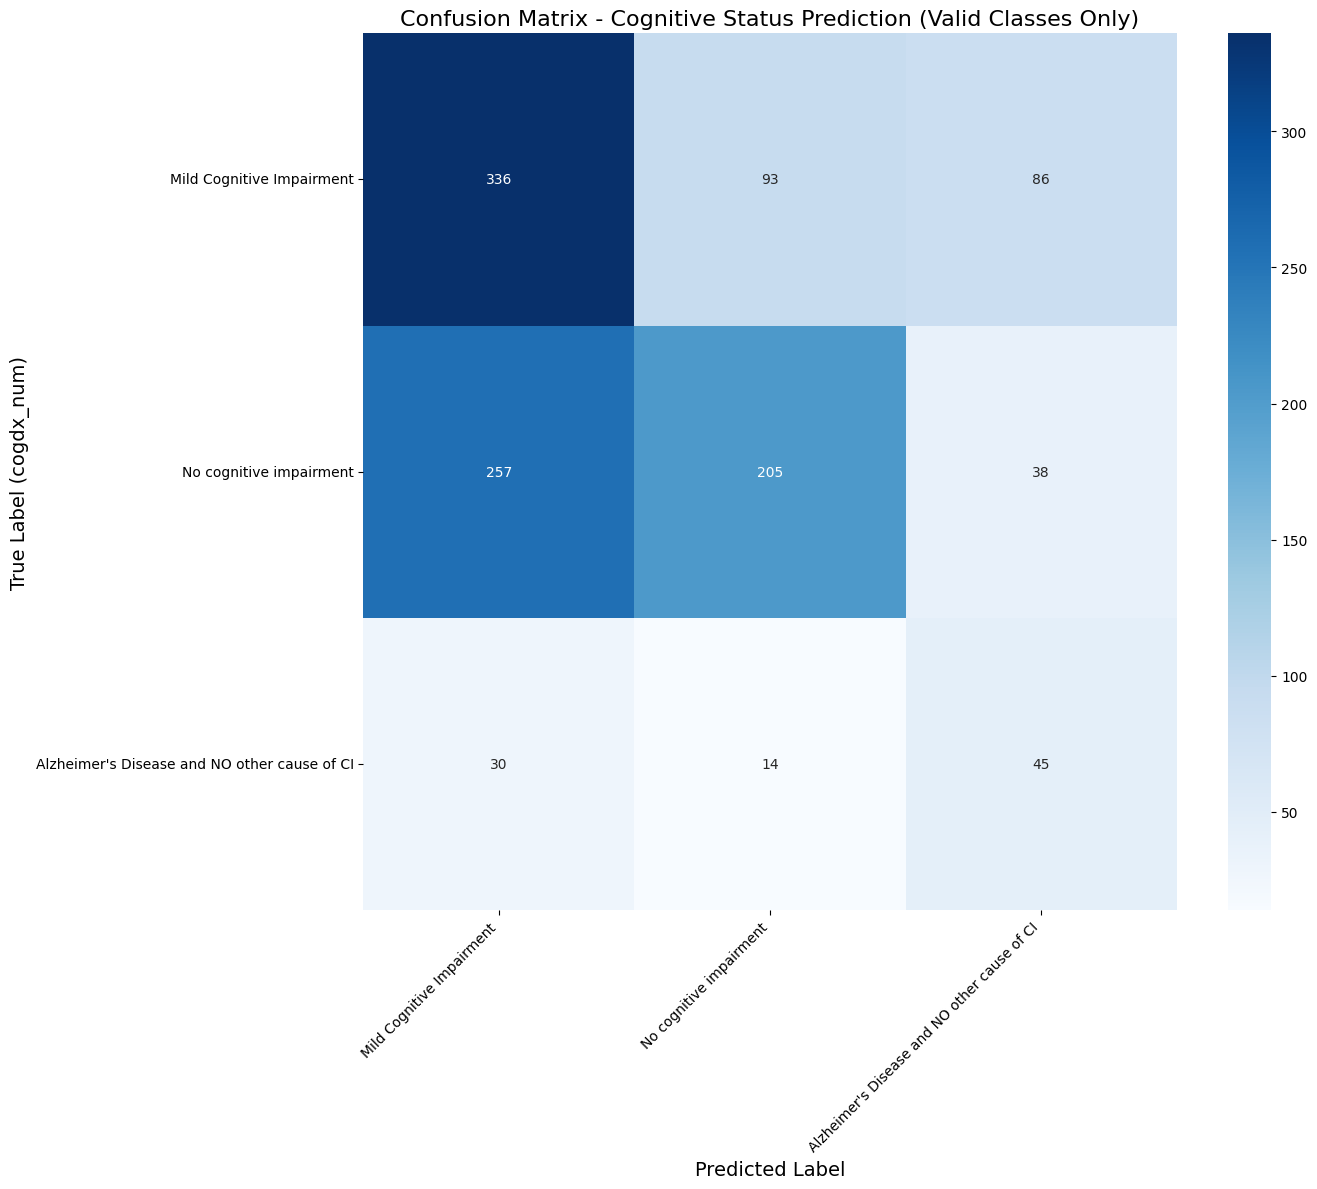


Detailed Classification Report (Valid Classes Only):
                                              precision    recall  f1-score   support

                   Mild Cognitive Impairment       0.54      0.65      0.59       517
                     No cognitive impairment       0.66      0.41      0.50       500
Alzheimer's Disease and NO other cause of CI       0.27      0.50      0.35        90

                                   micro avg       0.53      0.53      0.53      1107
                                   macro avg       0.49      0.52      0.48      1107
                                weighted avg       0.57      0.53      0.53      1107


Metrics DataFrame:
                                              precision    recall  f1-score  \
Mild Cognitive Impairment                      0.539326  0.649903  0.589474   
No cognitive impairment                        0.657051  0.410000  0.504926   
Alzheimer's Disease and NO other cause of CI   0.266272  0.500000  0.347490   
micro

In [8]:

##ADNI_othernn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path - use absolute path with home directory
file_path = os.path.expanduser("~/Downloads/test_predictions_Train_train_alln_ADNI_othernn.csv")

#file_path = os.path.expanduser("~/Downloads/models/Train_train_all_noDERpmin_ADNI_other_noDERpmin/cogdx_results_n1.5112/test_predictions.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")



File found at: /Users/martinnwadiugwu/Downloads/models/Train_train_alln_ROS_MAP2n2/test_predictions_Train_train_alln_ROS_MAP2n2.csv

Data Preview:
         ID  predicted_cogdx  cogdx_num
0  10100574                1        1.0
1  10101589                4        4.0
2  10202345                2        1.0
3  10203224                1        1.0
4  10205244                2        1.0

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Filtered dataset size: 589
Class distribution after filtering:
cogdx_num
4    204
1    189
2    149
5     29
6     10
3      8
Name: count, dtype: int64

Accuracy Ratio: 270/589 = 0.4584 (45.84%)


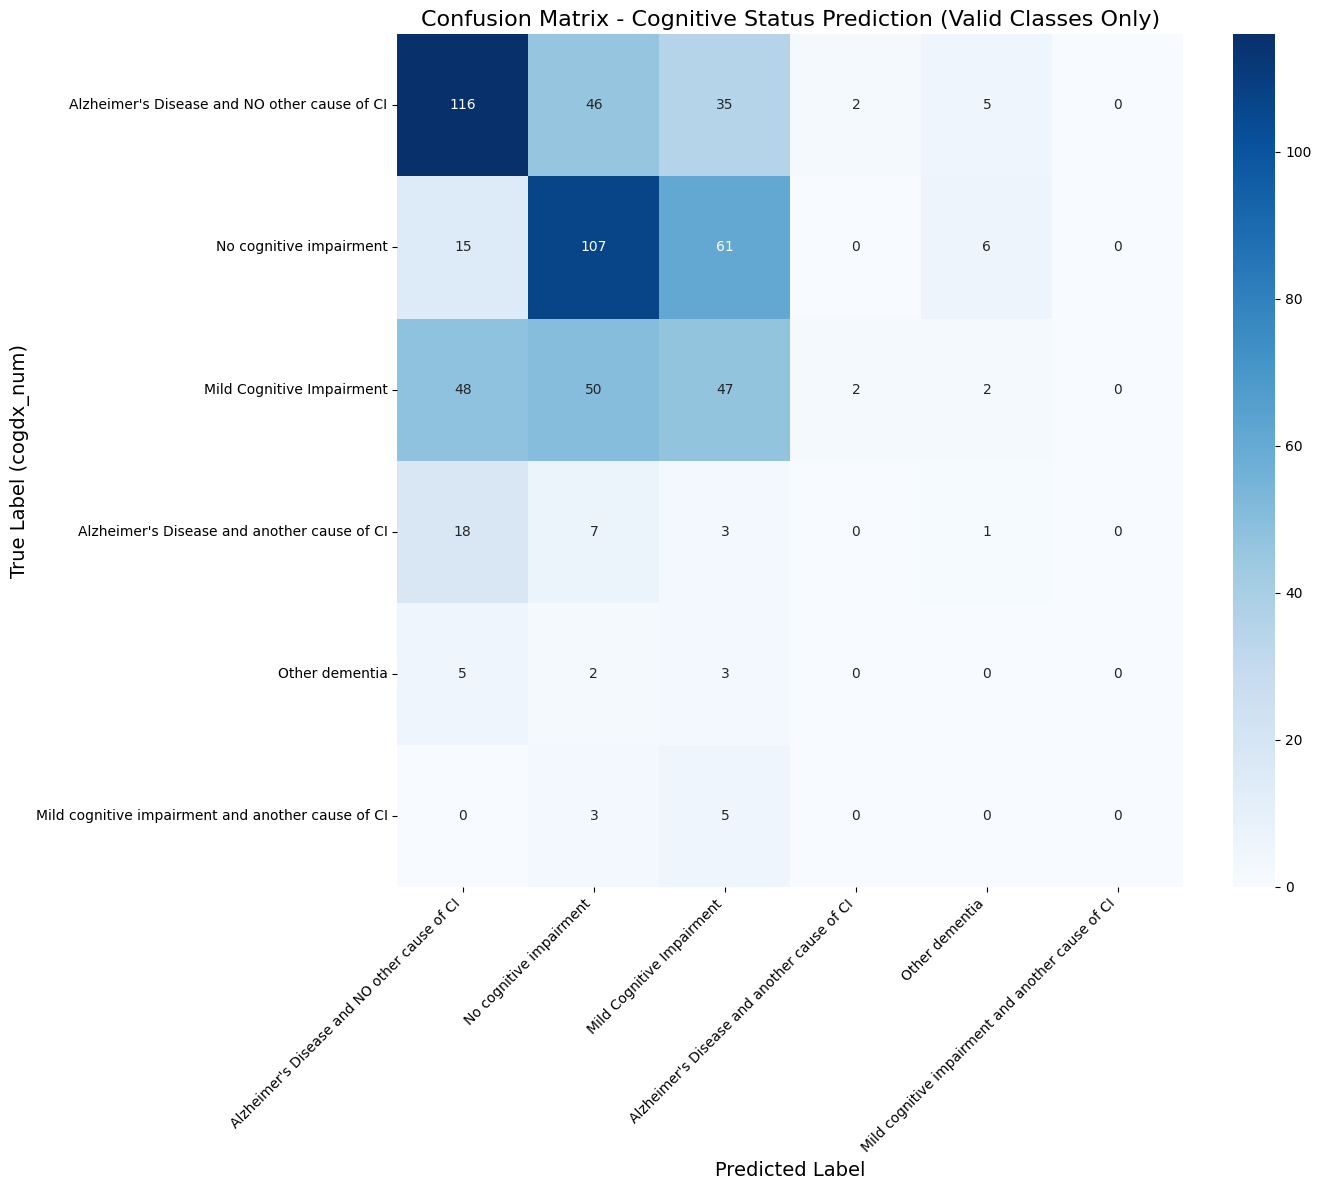


Detailed Classification Report (Valid Classes Only):
                                                   precision    recall  f1-score   support

     Alzheimer's Disease and NO other cause of CI       0.57      0.57      0.57       204
                          No cognitive impairment       0.50      0.57      0.53       189
                        Mild Cognitive Impairment       0.31      0.32      0.31       149
      Alzheimer's Disease and another cause of CI       0.00      0.00      0.00        29
                                   Other dementia       0.00      0.00      0.00        10
Mild cognitive impairment and another cause of CI       0.00      0.00      0.00         8

                                         accuracy                           0.46       589
                                        macro avg       0.23      0.24      0.24       589
                                     weighted avg       0.44      0.46      0.45       589


Metrics DataFrame:
             

In [11]:
##ROS_MAP2n2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path - use absolute path with home directory
file_path = os.path.expanduser("~/Downloads/models/Train_train_alln_ROS_MAP2n2/test_predictions_Train_train_alln_ROS_MAP2n2.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")



File found at: /Users/martinnwadiugwu/Downloads/models/Train_train_all_noDERpmin_ADNI_other_noDERpmin/cogdx_results_n1.5112/test_predictions.csv

Data Preview:
   ID  predicted_cogdx  true_cogdx  cogdx_num
0   2                1         NaN          1
1   7                4         NaN          4
2  15                2         NaN          1
3  21                1         NaN          1
4  30                1         NaN          2

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Found 3 predictions for invalid classes. These will be treated as errors.

Filtered dataset size: 1107
Class distribution after filtering:
cogdx_num
2    517
1    500
4     90
Name: count, dtype: int64

Accuracy Ratio: 624/1107 = 0.5637 (56.37%)


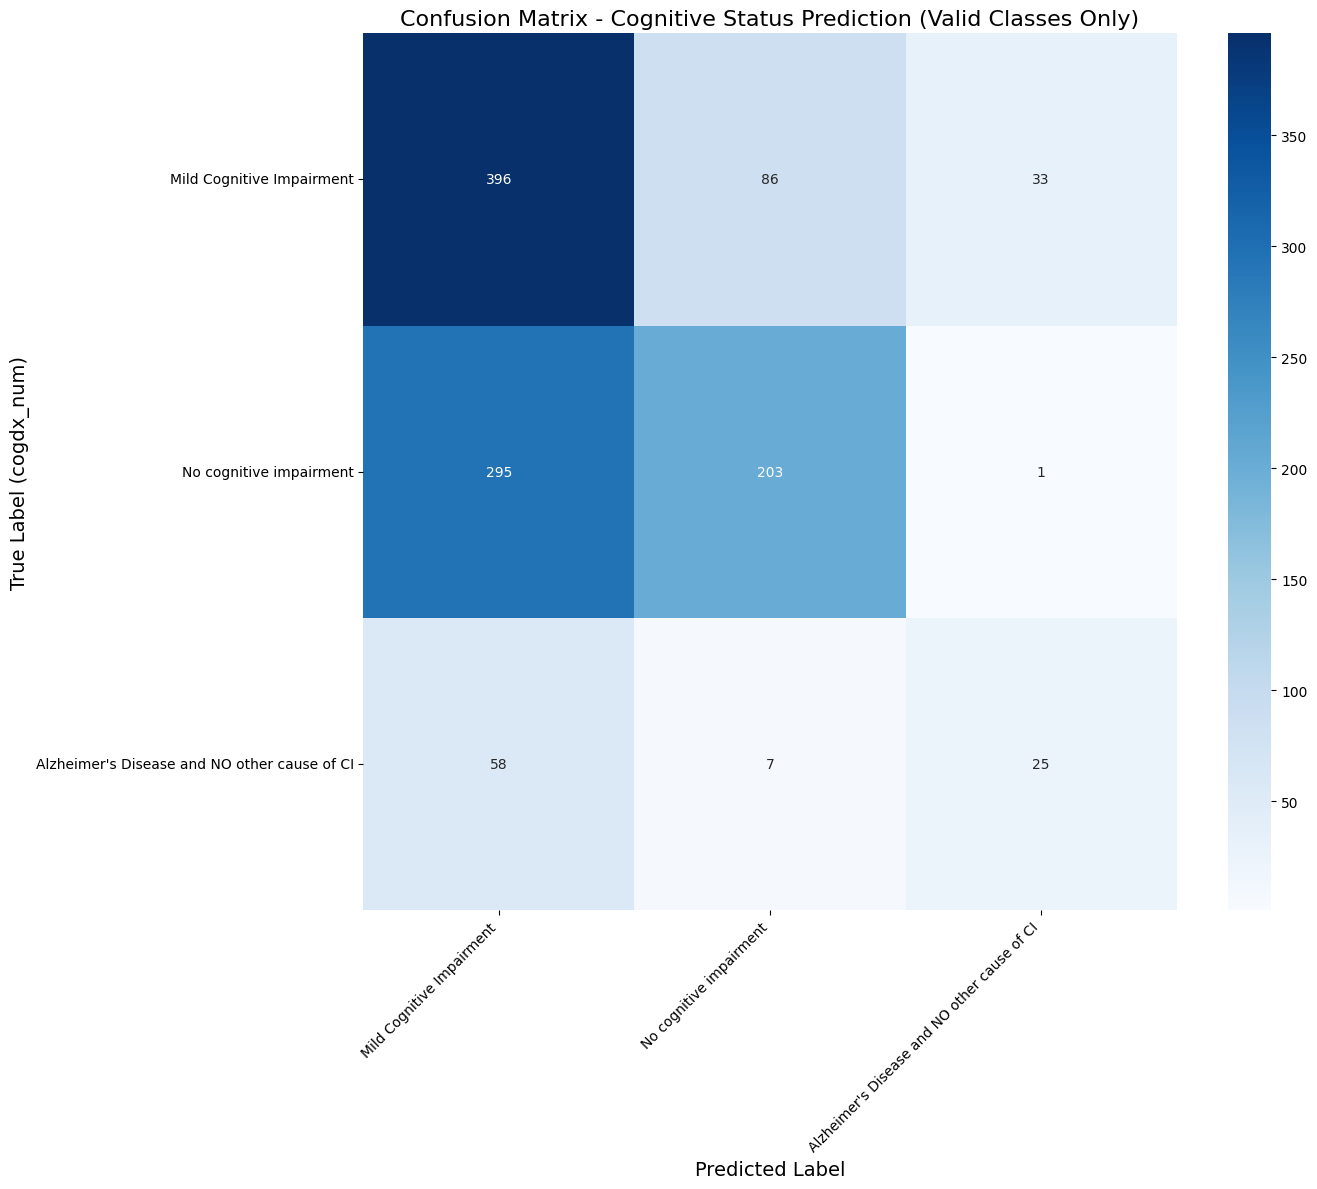


Detailed Classification Report (Valid Classes Only):
                                              precision    recall  f1-score   support

                   Mild Cognitive Impairment       0.53      0.77      0.63       517
                     No cognitive impairment       0.69      0.41      0.51       500
Alzheimer's Disease and NO other cause of CI       0.42      0.28      0.34        90

                                   micro avg       0.57      0.56      0.56      1107
                                   macro avg       0.55      0.48      0.49      1107
                                weighted avg       0.59      0.56      0.55      1107


Metrics DataFrame:
                                              precision    recall  f1-score  \
Mild Cognitive Impairment                      0.528705  0.765957  0.625592   
No cognitive impairment                        0.685811  0.406000  0.510050   
Alzheimer's Disease and NO other cause of CI   0.423729  0.277778  0.335570   
micro

In [12]:
##ADNI_other_noDERpmin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path
file_path = os.path.expanduser("~/Downloads/models/Train_train_all_noDERpmin_ADNI_other_noDERpmin/cogdx_results_n1.5112/test_predictions.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")

File found at: /Users/martinnwadiugwu/Downloads/models/Train_train_all_noDERpmi_ADNI_other_noDERpmi/cogdx_results_n1.5113/test_predictions.csv

Data Preview:
   ID  predicted_cogdx  true_cogdx  cogdx_num
0   2                1         NaN          1
1   7                4         NaN          4
2  15                1         NaN          1
3  21                1         NaN          1
4  30                2         NaN          2

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Found 2 predictions for invalid classes. These will be treated as errors.

Filtered dataset size: 1107
Class distribution after filtering:
cogdx_num
2    517
1    500
4     90
Name: count, dtype: int64

Accuracy Ratio: 997/1107 = 0.9006 (90.06%)


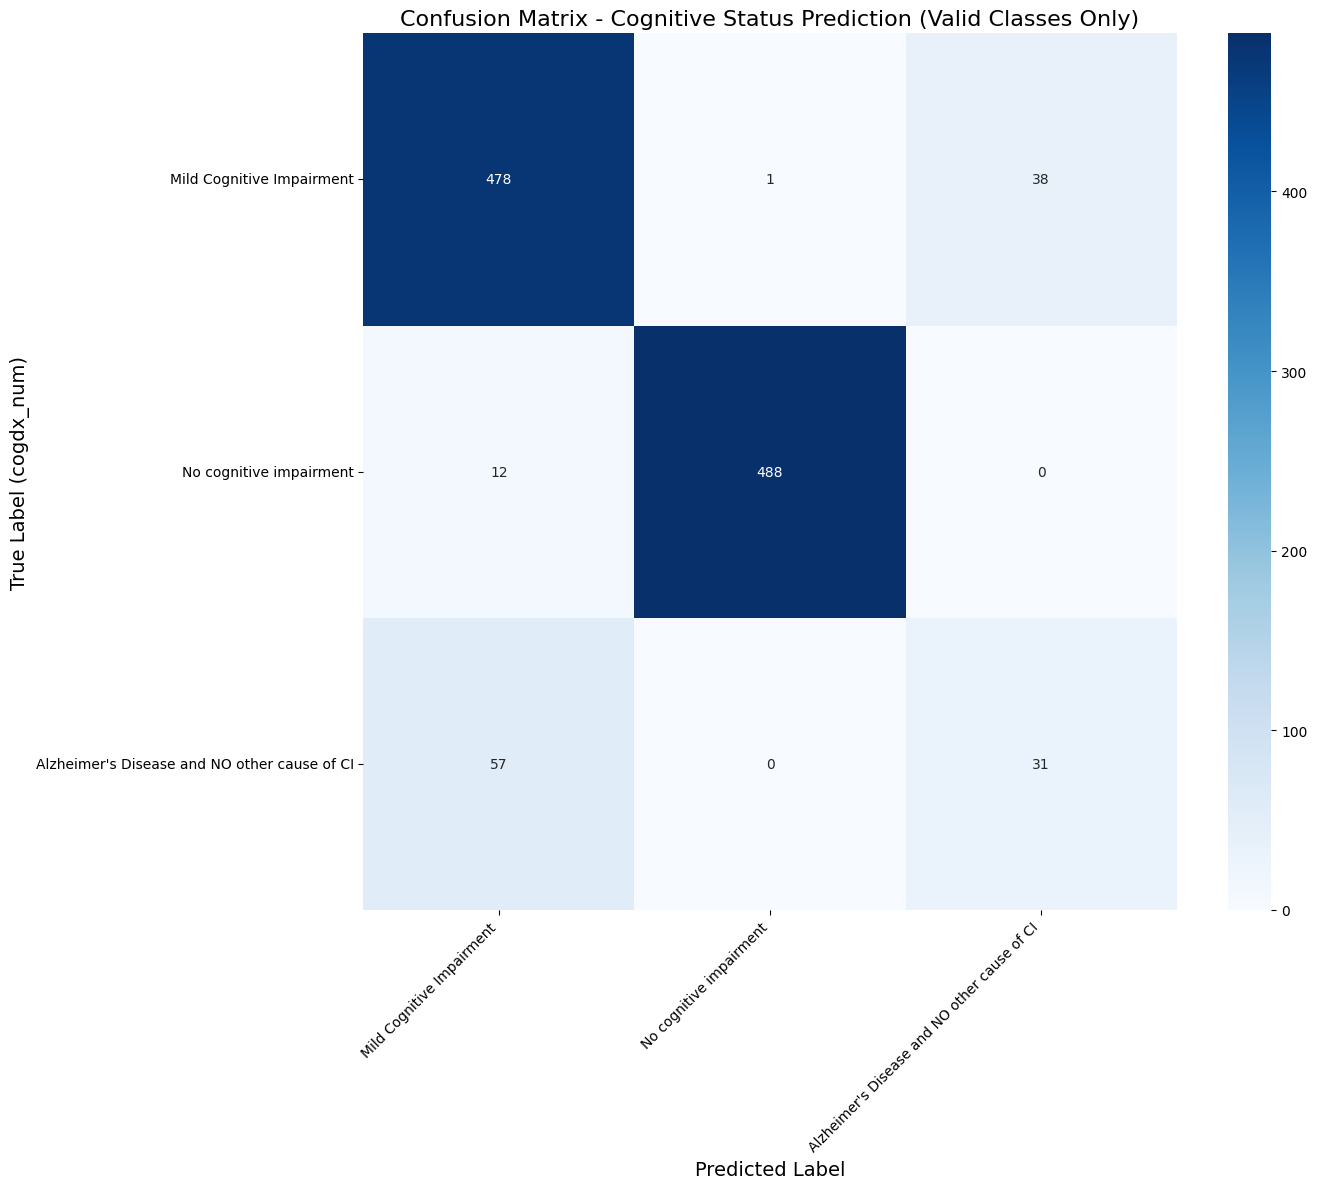


Detailed Classification Report (Valid Classes Only):
                                              precision    recall  f1-score   support

                   Mild Cognitive Impairment       0.87      0.92      0.90       517
                     No cognitive impairment       1.00      0.98      0.99       500
Alzheimer's Disease and NO other cause of CI       0.45      0.34      0.39        90

                                   micro avg       0.90      0.90      0.90      1107
                                   macro avg       0.77      0.75      0.76      1107
                                weighted avg       0.90      0.90      0.90      1107


Metrics DataFrame:
                                              precision    recall  f1-score  \
Mild Cognitive Impairment                      0.873857  0.924565  0.898496   
No cognitive impairment                        0.997955  0.976000  0.986855   
Alzheimer's Disease and NO other cause of CI   0.449275  0.344444  0.389937   
micro

In [13]:
#ADNI_other_noDERpmi

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path - use absolute path with home directory
file_path = os.path.expanduser("~/Downloads/models/Train_train_all_noDERpmi_ADNI_other_noDERpmi/cogdx_results_n1.5113/test_predictions.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")



File found at: /Users/martinnwadiugwu/Downloads/models/Train_train_all_noDERpmin_ADNI_other_noDERpmin/cogdx_results_n1.5112/test_predictions.csv

Data Preview:
   ID  predicted_cogdx  true_cogdx  cogdx_num
0   2                1         NaN          1
1   7                4         NaN          4
2  15                2         NaN          1
3  21                1         NaN          1
4  30                1         NaN          2

Missing Values Check:
predicted_cogdx    0
cogdx_num          0
dtype: int64

Found 3 predictions for invalid classes. These will be treated as errors.

Filtered dataset size: 1107
Class distribution after filtering:
cogdx_num
2    517
1    500
4     90
Name: count, dtype: int64

Accuracy Ratio: 624/1107 = 0.5637 (56.37%)


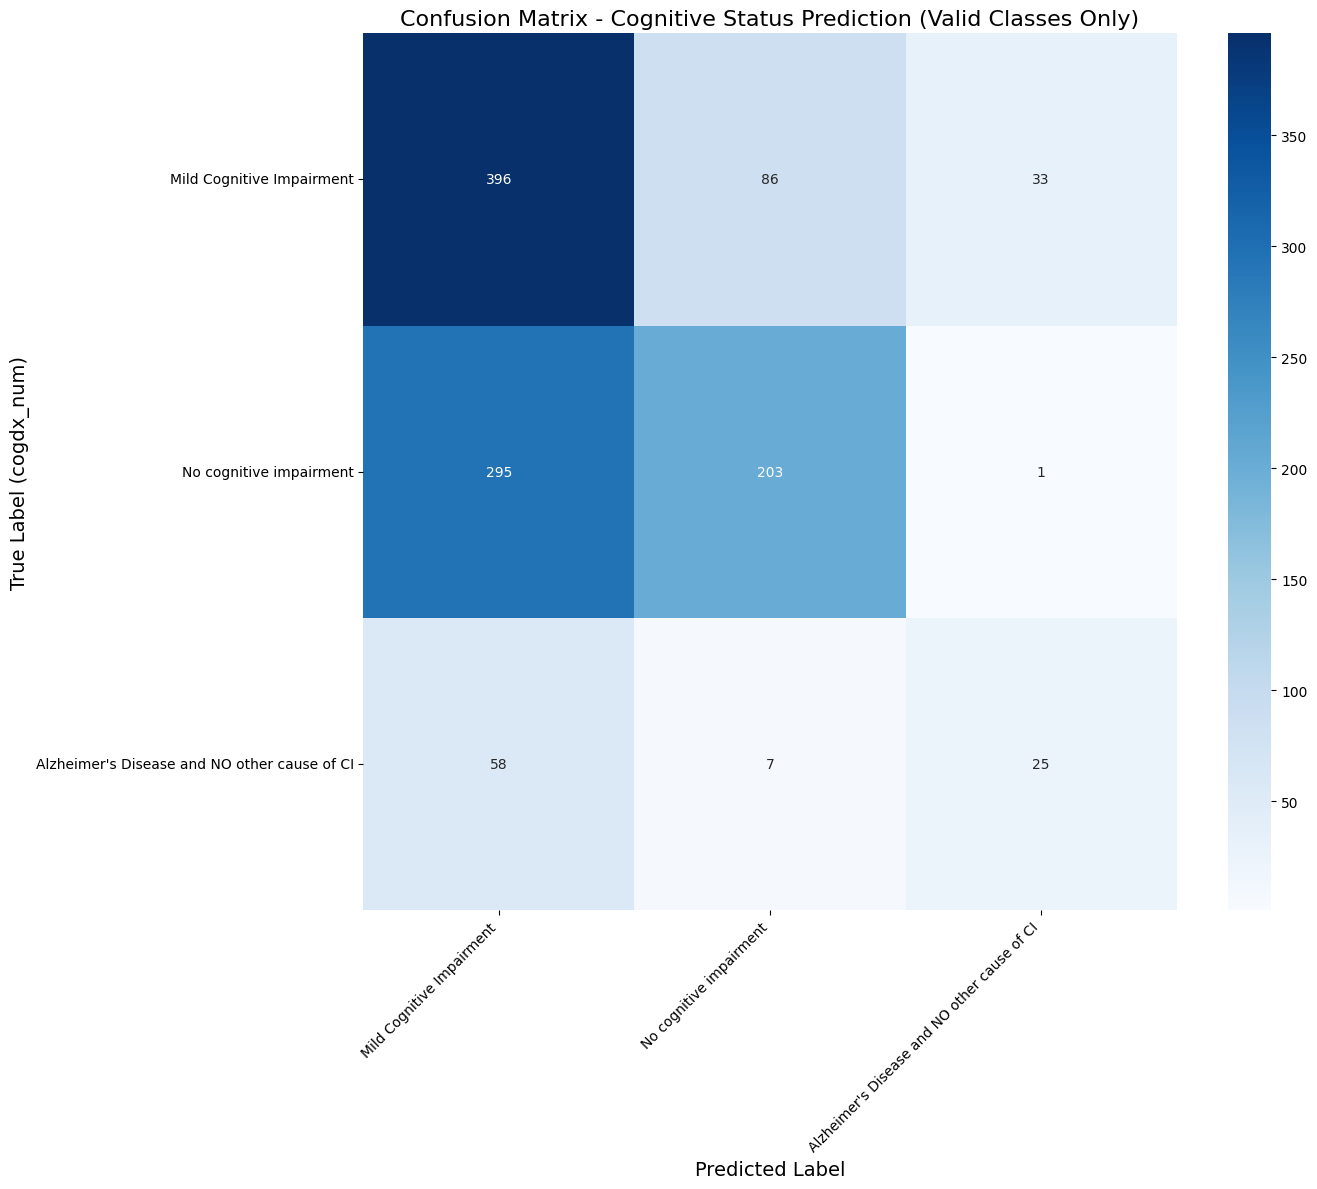


Detailed Classification Report (Valid Classes Only):
                                              precision    recall  f1-score   support

                   Mild Cognitive Impairment       0.53      0.77      0.63       517
                     No cognitive impairment       0.69      0.41      0.51       500
Alzheimer's Disease and NO other cause of CI       0.42      0.28      0.34        90

                                   micro avg       0.57      0.56      0.56      1107
                                   macro avg       0.55      0.48      0.49      1107
                                weighted avg       0.59      0.56      0.55      1107


Metrics DataFrame:
                                              precision    recall  f1-score  \
Mild Cognitive Impairment                      0.528705  0.765957  0.625592   
No cognitive impairment                        0.685811  0.406000  0.510050   
Alzheimer's Disease and NO other cause of CI   0.423729  0.277778  0.335570   
micro

In [15]:
##ADNI_other_noDERpmin

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import os

# Define the status mapping
STATUS_MAP = {
    1: "No cognitive impairment",
    2: "Mild Cognitive Impairment",
    3: "Mild cognitive impairment and another cause of CI",
    4: "Alzheimer's Disease and NO other cause of CI",
    5: "Alzheimer's Disease and another cause of CI",
    6: "Other dementia"
}

# Corrected file path - use absolute path with home directory
file_path = os.path.expanduser("~/Downloads/models/Train_train_all_noDERpmin_ADNI_other_noDERpmin/cogdx_results_n1.5112/test_predictions.csv")

# Verify file exists
if not os.path.exists(file_path):
    print(f"ERROR: File not found at {file_path}")
    print("Please verify the file exists at this location.")
else:
    print(f"File found at: {file_path}")
    
    # Load the CSV file
    df = pd.read_csv(file_path)
    
    # Display first few rows
    print("\nData Preview:")
    print(df.head())
    
    # Check for required columns
    required_columns = ['predicted_cogdx', 'cogdx_num']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        print(f"\nERROR: Missing columns: {', '.join(missing_cols)}")
        print("Available columns:", df.columns.tolist())
    else:
        # Check for missing values
        print("\nMissing Values Check:")
        print(df[required_columns].isnull().sum())
    
        # Convert to integers
        df['cogdx_num'] = df['cogdx_num'].astype(int)
        df['predicted_cogdx'] = df['predicted_cogdx'].astype(int)
        
        # Identify classes with actual support
        class_counts = df['cogdx_num'].value_counts()
        valid_classes = class_counts[class_counts > 0].index.tolist()
        
        # Filter both true and predicted labels to only include valid classes
        df_filtered = df[df['cogdx_num'].isin(valid_classes)].copy()
        
        # Also remove predictions for invalid classes (treat them as misclassifications)
        # This is important because if the model predicts a class that doesn't exist in the test set,
        # we should count it as an error
        invalid_predictions = ~df_filtered['predicted_cogdx'].isin(valid_classes)
        if invalid_predictions.sum() > 0:
            print(f"\nFound {invalid_predictions.sum()} predictions for invalid classes. These will be treated as errors.")
            # You could choose to mark these as a specific error code or just leave them as is
            # For now, we'll just note them but not change the values
        
        print(f"\nFiltered dataset size: {len(df_filtered)}")
        print("Class distribution after filtering:")
        print(df_filtered['cogdx_num'].value_counts())
    
        # Calculate accuracy
        correct_predictions = (df_filtered['predicted_cogdx'] == df_filtered['cogdx_num']).sum()
        total_samples = len(df_filtered)
        accuracy = correct_predictions / total_samples

        print(f"\nAccuracy Ratio: {correct_predictions}/{total_samples} = {accuracy:.4f} ({accuracy*100:.2f}%)")
    
        # Generate confusion matrix - only include valid classes
        cm = confusion_matrix(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes
        )
        
        # Create labels for matrix using STATUS_MAP
        labels = [STATUS_MAP.get(label, f'Unknown ({label})') for label in valid_classes]
        
        # Plot confusion matrix
        plt.figure(figsize=(14, 12))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
        plt.title('Confusion Matrix - Cognitive Status Prediction (Valid Classes Only)', fontsize=16)
        plt.xlabel('Predicted Label', fontsize=14)
        plt.ylabel('True Label (cogdx_num)', fontsize=14)
        plt.xticks(rotation=45, ha='right', fontsize=10)
        plt.yticks(rotation=0, fontsize=10)
        plt.tight_layout()
        plt.show()
        
        # Classification report - only include valid classes
        print("\nDetailed Classification Report (Valid Classes Only):")
        report = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            zero_division=0
        )
        print(report)
        
        # Convert classification report to DataFrame for better visualization
        report_dict = classification_report(
            df_filtered['cogdx_num'], 
            df_filtered['predicted_cogdx'],
            labels=valid_classes,
            target_names=[STATUS_MAP.get(i, f'Unknown ({i})') for i in valid_classes],
            output_dict=True,
            zero_division=0
        )
        metrics_df = pd.DataFrame(report_dict).transpose()
        print("\nMetrics DataFrame:")
        print(metrics_df)
        
        # Additional analysis: Class-wise performance
        print("\nAdditional Analysis:")
        print("=" * 50)
        
        # Calculate class-wise accuracy
        for class_label in valid_classes:
            class_data = df_filtered[df_filtered['cogdx_num'] == class_label]
            class_accuracy = (class_data['predicted_cogdx'] == class_data['cogdx_num']).mean()
            print(f"{STATUS_MAP.get(class_label, f'Unknown ({class_label})')}: {class_accuracy:.2%} accuracy")
        
        # Most common misclassifications
        misclassifications = df_filtered[df_filtered['predicted_cogdx'] != df_filtered['cogdx_num']]
        if len(misclassifications) > 0:
            print(f"\nMost common misclassifications:")
            misclass_counts = misclassifications.groupby(['cogdx_num', 'predicted_cogdx']).size().reset_index(name='count')
            misclass_counts = misclass_counts.sort_values('count', ascending=False)
            
            for _, row in misclass_counts.head().iterrows():
                true_label = STATUS_MAP.get(row['cogdx_num'], f'Unknown ({row["cogdx_num"]})')
                pred_label = STATUS_MAP.get(row['predicted_cogdx'], f'Unknown ({row["predicted_cogdx"]})')
                print(f"  {true_label} → {pred_label}: {row['count']} cases")
        
        # Check for predictions of invalid classes
        invalid_preds = df_filtered[~df_filtered['predicted_cogdx'].isin(valid_classes)]
        if len(invalid_preds) > 0:
            print(f"\nWARNING: {len(invalid_preds)} predictions are for classes not present in the test set:")
            for class_label in invalid_preds['predicted_cogdx'].unique():
                count = (invalid_preds['predicted_cogdx'] == class_label).sum()
                print(f"  Class {class_label} ({STATUS_MAP.get(class_label, 'Unknown')}): {count} predictions")

